<a href="https://colab.research.google.com/github/Obs25/Military-Soldier-Safety-and-Weapon-Detection-using-YOLO-and-Computer-Vision/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


### Set Dataset Path

In [ ]:

BASE_PATH = 'D:/Final_project/military_object_dataset'
SPLITS = ['train', 'val', 'test']
IMG_SIZE = (640, 640)


### Define Annotation Validator

In [ ]:
def is_valid_yolo_annotation(filepath):
    try:
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    return False
                floats = list(map(float, parts[1:]))
                if not all(0 <= val <= 1 for val in floats):
                    return False
        return True
    except:
        return False


### 4. Process All Images and Labels

In [ ]:
# This function validates each .txt file
def is_valid_yolo_annotation(filepath):
    try:
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    return False
                floats = list(map(float, parts[1:]))
                if not all(0 <= val <= 1 for val in floats):
                    return False
        return True
    except:
        return False


### Preprocess and Resize Images + Check Annotations

In [ ]:
for split in SPLITS:
    img_dir = os.path.join(BASE_PATH, split, 'images')
    lbl_dir = os.path.join(BASE_PATH, split, 'labels')

    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]

    for img_file in tqdm(image_files, desc=f"Processing {split}"):
        img_path = os.path.join(img_dir, img_file)
        label_path = os.path.join(lbl_dir, os.path.splitext(img_file)[0] + '.txt')

        # Check annotation exists
        if not os.path.exists(label_path):
            print(f"Missing label for: {img_file}")
            continue

        # Check annotation format
        if not is_valid_yolo_annotation(label_path):
            print(f"Invalid YOLO format: {label_path}")
            continue

        #  Resize image to 640x640
        try:
            image = cv2.imread(img_path)
            if image is not None:
                resized = cv2.resize(image, IMG_SIZE)
                cv2.imwrite(img_path, resized)
            else:
                print(f"Unreadable image: {img_path}")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")


Processing train:  24%|██▍       | 5221/21978 [01:16<04:49, 57.92it/s] 

❌ Invalid YOLO format: D:/Final_project/military_object_dataset\train\labels\006101.txt


Processing train:  65%|██████▌   | 14286/21978 [03:55<01:55, 66.53it/s] 

❌ Invalid YOLO format: D:/Final_project/military_object_dataset\train\labels\017230.txt
❌ Invalid YOLO format: D:/Final_project/military_object_dataset\train\labels\017236.txt
❌ Invalid YOLO format: D:/Final_project/military_object_dataset\train\labels\017247.txt


Processing train:  65%|██████▌   | 14385/21978 [03:57<01:48, 70.12it/s]

❌ Invalid YOLO format: D:/Final_project/military_object_dataset\train\labels\017320.txt


Processing train:  70%|██████▉   | 15353/21978 [04:11<01:13, 90.05it/s] 

❌ Invalid YOLO format: D:/Final_project/military_object_dataset\train\labels\018290.txt


Processing train:  70%|██████▉   | 15383/21978 [04:11<01:23, 79.25it/s]

❌ Invalid YOLO format: D:/Final_project/military_object_dataset\train\labels\018332.txt


Processing train:  70%|███████   | 15410/21978 [04:12<01:34, 69.33it/s]

❌ Invalid YOLO format: D:/Final_project/military_object_dataset\train\labels\018353.txt
❌ Invalid YOLO format: D:/Final_project/military_object_dataset\train\labels\018359.txt


Processing train:  71%|███████   | 15539/21978 [04:14<01:43, 61.95it/s]

❌ Invalid YOLO format: D:/Final_project/military_object_dataset\train\labels\018487.txt


Processing test:   1%|          | 17/1396 [00:00<00:17, 80.11it/s]

❌ Invalid YOLO format: D:/Final_project/military_object_dataset\test\labels\000003.txt


Processing test: 100%|██████████| 1396/1396 [00:26<00:00, 53.08it/s] 


### Summary After Preprocessing

In [ ]:

for split in SPLITS:
    img_dir = os.path.join(BASE_PATH, split, 'images')
    lbl_dir = os.path.join(BASE_PATH, split, 'labels')

    num_images = len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
    num_labels = len([f for f in os.listdir(lbl_dir) if f.endswith('.txt')])

    print(f"{split.upper()}: {num_images} images, {num_labels} label files")



TRAIN: 21978 images, 21978 label files
VAL: 2941 images, 2941 label files
TEST: 1396 images, 1396 label files


# EDA

In [ ]:
CLASS_NAMES = {
    0: 'camouflage_soldier',
    1: 'weapon',
    2: 'military_tank',
    3: 'military_truck',
    4: 'military_vehicle',
    5: 'civilian',
    6: 'soldier',
    7: 'civilian_vehicle',
    8: 'trench'
}

### Parse YOLO Labels to DataFrame

In [ ]:
def parse_yolo_labels(split):
    label_dir = os.path.join(BASE_PATH, split, 'labels')
    image_dir = os.path.join(BASE_PATH, split, 'images')

    data = []

    for file in tqdm(os.listdir(label_dir), desc=f"Parsing {split}"):
        if not file.endswith('.txt'):
            continue
        label_path = os.path.join(label_dir, file)
        image_path = os.path.join(image_dir, file.replace('.txt', '.jpg'))
        if not os.path.exists(image_path):
            image_path = image_path.replace('.jpg', '.png')
        if not os.path.exists(image_path):
            continue

        img = cv2.imread(image_path)
        if img is None:
            continue
        h, w, _ = img.shape

        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, x, y, bw, bh = map(float, parts)
                data.append({
                    'filename': file.replace('.txt', ''),
                    'class_id': int(cls),
                    'class_name': CLASS_NAMES.get(int(cls), str(int(cls))),
                    'x_center': x,
                    'y_center': y,
                    'width': bw,
                    'height': bh,
                    'bbox_width_px': bw * w,
                    'bbox_height_px': bh * h,
                    'image_width': w,
                    'image_height': h
                })
    return pd.DataFrame(data)

df_train = parse_yolo_labels('train')


Parsing train:   0%|          | 0/21978 [00:00<?, ?it/s]

Parsing train: 100%|██████████| 21978/21978 [02:44<00:00, 133.59it/s]


### Class Distribution Plot

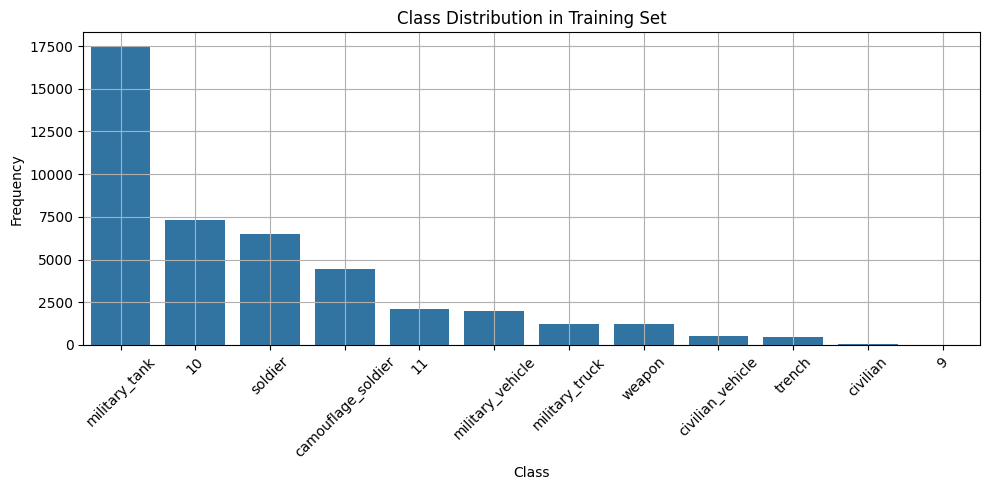

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_train, x='class_name', order=df_train['class_name'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


### Bounding Box Size Distributions

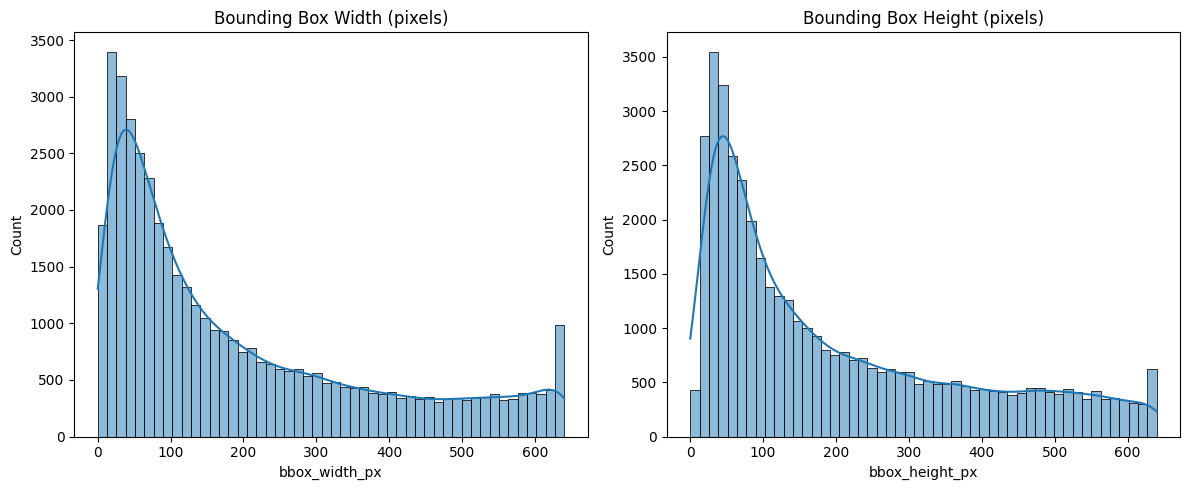

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_train['bbox_width_px'], bins=50, kde=True)
plt.title('Bounding Box Width (pixels)')

plt.subplot(1, 2, 2)
sns.histplot(df_train['bbox_height_px'], bins=50, kde=True)
plt.title('Bounding Box Height (pixels)')

plt.tight_layout()
plt.show()


### Boxes per Image

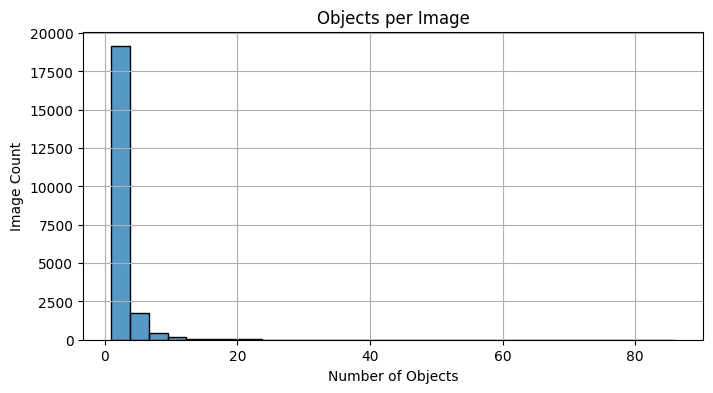

In [ ]:
box_counts = df_train['filename'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(box_counts, bins=30)
plt.title('Objects per Image')
plt.xlabel('Number of Objects')
plt.ylabel('Image Count')
plt.grid(True)
plt.show()


### Heatmap of Object Locations

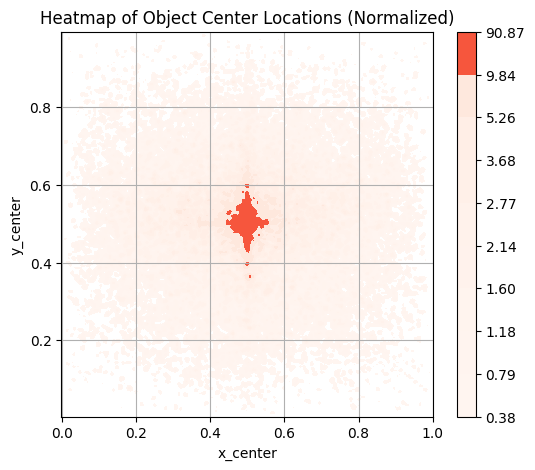

In [ ]:
plt.figure(figsize=(6, 5))
sns.kdeplot(
    x=df_train['x_center'],
    y=df_train['y_center'],
    cmap='Reds',
    fill=True,
    bw_adjust=0.1,
    cbar=True
)
plt.title('Heatmap of Object Center Locations (Normalized)')
plt.xlabel('x_center')
plt.ylabel('y_center')
plt.grid(True)
plt.show()


Visualize Sample Image with Annotations

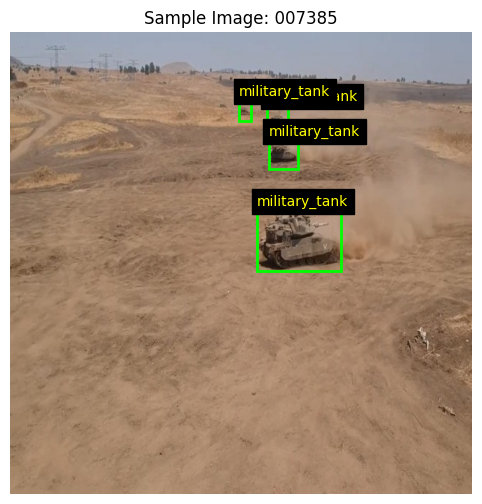

In [ ]:


def show_sample_image(df):
    sample_row = df.sample(1).iloc[0]
    fname = sample_row['filename']
    img_path = os.path.join(BASE_PATH, 'train', 'images', fname + '.jpg')
    if not os.path.exists(img_path):
        img_path = img_path.replace('.jpg', '.png')

    img = cv2.imread(img_path)
    if img is None:
        print("Image not found.")
        return

    h, w, _ = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)

    boxes = df[df['filename'] == fname]
    for _, row in boxes.iterrows():
        xc, yc = row['x_center'] * w, row['y_center'] * h
        bw, bh = row['width'] * w, row['height'] * h
        x1 = int(xc - bw / 2)
        y1 = int(yc - bh / 2)
        plt.gca().add_patch(plt.Rectangle((x1, y1), bw, bh, edgecolor='lime', facecolor='none', linewidth=2))
        plt.text(x1, y1 - 5, row['class_name'], color='yellow', fontsize=10, backgroundcolor='black')

    plt.title(f"Sample Image: {fname}")
    plt.axis('off')
    plt.show()

# Show a random sample
show_sample_image(df_train)


### Class Co-occurrence Heatmap


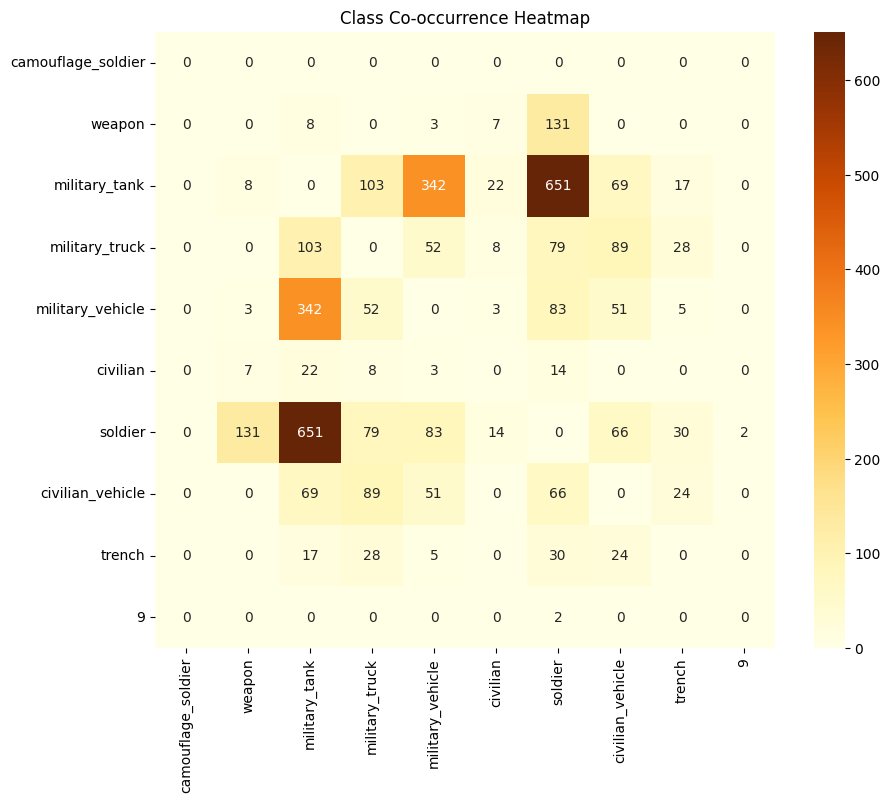

In [ ]:
# Create image-wise class set
image_class_map = df_train.groupby('filename')['class_name'].apply(set)

# Count co-occurrences
from itertools import combinations
from collections import defaultdict

co_occurrence = defaultdict(int)

for classes in image_class_map:
    for combo in combinations(sorted(classes), 2):
        co_occurrence[combo] += 1

# Convert to square matrix
labels = list(CLASS_NAMES.values())
matrix = matrix.fillna(0).astype(int)

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Class Co‑occurrence Heatmap')
plt.show()




### Class-wise Bounding Box Size

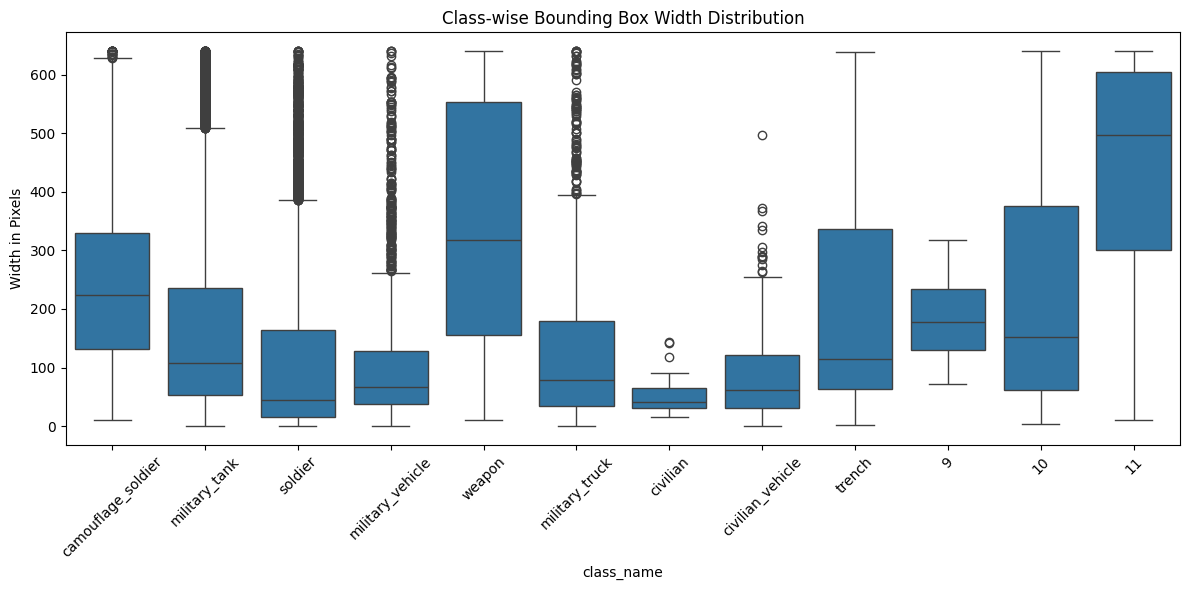

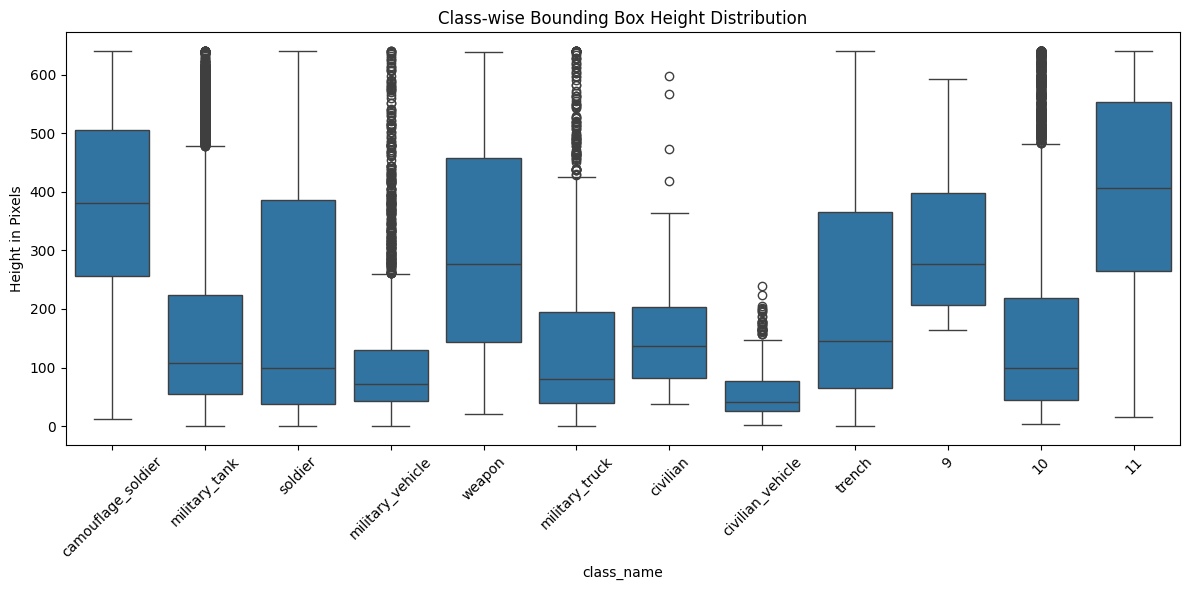

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train, x='class_name', y='bbox_width_px')
plt.xticks(rotation=45)
plt.title("Class-wise Bounding Box Width Distribution")
plt.ylabel("Width in Pixels")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train, x='class_name', y='bbox_height_px')
plt.xticks(rotation=45)
plt.title("Class-wise Bounding Box Height Distribution")
plt.ylabel("Height in Pixels")
plt.tight_layout()
plt.show()


###  Blurry Image Detection (Image Quality Check)

In [ ]:
def is_blurry(img_path, threshold=100.0):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    fm = cv2.Laplacian(img, cv2.CV_64F).var()
    return fm < threshold

blurry_count = 0
sample_paths = df_train['filename'].sample(200).values  # Sample 200 for speed

for name in sample_paths:
    img_path = os.path.join(BASE_PATH, 'train', 'images', name + '.jpg')
    if not os.path.exists(img_path):
        img_path = img_path.replace('.jpg', '.png')
    result = is_blurry(img_path)
    if result is True:
        blurry_count += 1

print(f"🧪 Found {blurry_count} blurry images out of 200 sampled (~{blurry_count/200:.2%})")


🧪 Found 0 blurry images out of 200 sampled (~0.00%)


### Small Object Detection Challenge

🔍 Small objects (< 20 px in width/height): 4306 / 43314 = 9.94%


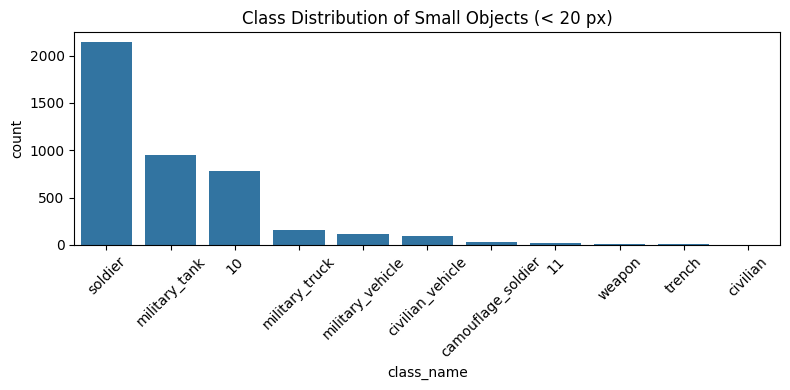

In [ ]:
# Count how many bounding boxes are small
small_w = df_train['bbox_width_px'] < 20
small_h = df_train['bbox_height_px'] < 20
small_objects = df_train[small_w | small_h]

print(f"🔍 Small objects (< 20 px in width/height): {len(small_objects)} / {len(df_train)} = {(len(small_objects)/len(df_train))*100:.2f}%")

plt.figure(figsize=(8, 4))
sns.countplot(data=small_objects, x='class_name', order=small_objects['class_name'].value_counts().index)
plt.title("Class Distribution of Small Objects (< 20 px)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Annotation Quality Check (Suspicious Annotations)

In [ ]:
# Annotations with bbox size = 0
zero_width = df_train[df_train['bbox_width_px'] == 0]
zero_height = df_train[df_train['bbox_height_px'] == 0]
zero_combined = pd.concat([zero_width, zero_height]).drop_duplicates()

print(f"⚠️ Found {len(zero_combined)} annotations with zero-size bounding boxes.")

# Show a few examples
zero_combined[['filename', 'class_name', 'bbox_width_px', 'bbox_height_px']].head()


⚠️ Found 15 annotations with zero-size bounding boxes.


,filename,class_name,bbox_width_px,bbox_height_px
14186,007947,military_tank,0.0,1.185185
17049,009184,military_tank,0.0,0.000000
17120,009195,military_tank,0.0,1.000000
17257,009212,soldier,0.0,0.000000
19030,009592,soldier,0.0,1.000000


### Clean Cell: Remove Zero-Size Annotations from Label Files



In [ ]:
def clean_small_pixel_bboxes(split='train', threshold_px=1):
    label_dir = os.path.join(BASE_PATH, split, 'labels')
    image_dir = os.path.join(BASE_PATH, split, 'images')

    removed_count = 0

    for fname in tqdm(os.listdir(label_dir), desc="Cleaning near-zero pixel boxes"):
        if not fname.endswith('.txt'):
            continue

        txt_path = os.path.join(label_dir, fname)
        img_path_jpg = os.path.join(image_dir, fname.replace('.txt', '.jpg'))
        img_path_png = os.path.join(image_dir, fname.replace('.txt', '.png'))
        img_path = img_path_jpg if os.path.exists(img_path_jpg) else img_path_png

        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w, _ = img.shape

        cleaned_lines = []
        with open(txt_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, xc, yc, bw, bh = map(float, parts)
                if bw * w >= threshold_px and bh * h >= threshold_px:
                    cleaned_lines.append(line)
                else:
                    removed_count += 1

        with open(txt_path, 'w') as f:
            f.writelines(cleaned_lines)

    print(f"✅ Removed {removed_count} annotations with <{threshold_px}px size.")

clean_small_pixel_bboxes(split='train', threshold_px=1)



Cleaning near-zero pixel boxes: 100%|██████████| 21978/21978 [02:31<00:00, 145.42it/s]

✅ Removed 7 annotations with <1px size.
✅ After cleaning: 15 annotations with zero-size boxes remain.


In [ ]:
# Rerun the same function from earlier to rebuild the DataFrame
df_train = parse_yolo_labels('train')

# Recheck for zero-size bounding boxes
zero_w = df_train[df_train['bbox_width_px'] < 1]
zero_h = df_train[df_train['bbox_height_px'] < 1]
zero_combined = pd.concat([zero_w, zero_h]).drop_duplicates()

print(f"✅ After reloading: {len(zero_combined)} annotations with <1px size remain.")



Parsing train:   0%|          | 0/21978 [00:00<?, ?it/s]

Parsing train: 100%|██████████| 21978/21978 [02:12<00:00, 165.95it/s]

✅ After reloading: 0 annotations with <1px size remain.


# YOLOv8 Training